# Exercise Sheet 02: Principal Component Analysis, Factor Analysis, K-Means, and Gaussian Mixture Models

**Introduction to Data Mining WS23/24**  
**Bielefeld University**  
**Alina Deriyeva, Benjamin Paaßen**  
**Exercise Sheet Publication Date: 2023-11-06**  
**Exercise Sheet Submission Deadline: 2023-11-17, noon (i.e. 12:00), via **moodle** (please do not use e-mail submissions anymore).

**NOTE** The use of language models/AI tools is permitted IF you notify us of the use (just indicate it in the respective task) and are still able to understand and present your results. We also appreciate it if you link to a chatlog of the interaction with the language model/AI tool so that we can understand better how students tend to use these tools.

**PLEASE INDICATE ALL AUTHORS OF THE SUBMISSION IN THIS FIELD**

## Preamble: Data set

The file `sheet02_data.csv` contains fictional data as you might find in an online course. Each row represents a student, each column a feature of the student's activity in the course, namely their number of posts in the course discussion forum, the number of questions they asked in chat during the online lectures, the number of messages they sent to their peers, and the number of points they achieved in each of the five exercises of the course.

Note that there is quite a bit of missing data for later exercises because many students dropped out of the course early.

The following code loads this raw data and prints it.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.decomposition

features = ['num_forum_postings',
            'num_questions',
            'num_messages',
            'num_completed_tasks',
            'points_exercise_1',
            'points_exercise_2',
            'points_exercise_3',
            'points_exercise_4',
            'points_exercise_5']

X = np.loadtxt('sheet02_data.csv', skiprows=1, delimiter='\t')
print(X)
print(X.shape)

[[ 3.  1.  1. ... 56. 61. 60.]
 [ 0.  0.  0. ... nan nan nan]
 [ 7.  3.  2. ... 66. 57. nan]
 ...
 [ 0.  0.  0. ... 30. nan nan]
 [ 1.  0.  0. ... nan nan nan]
 [ 3.  0.  1. ... 40. 35. 40.]]
(284, 9)


### Task 02.01

Our first challenge is to impute the missing data. Fill in missing values with the mean points the respective student got on the other exercises. For students with no completed exercises, fill in zeros.

In [4]:
test_scores = X[:, 4:]
means = np.nanmean(test_scores, axis=1)
means[np.where(np.isnan(means))] = 0
means = np.concatenate([[means]] * 5, axis=0).T
test_scores = np.where(np.isnan(test_scores), means, test_scores)
X[:, 4:] = test_scores

C:\Users\Christoph\AppData\Local\Temp\ipykernel_20120\3061792849.py:2: RuntimeWarning: Mean of empty slice
  means = np.nanmean(test_scores, axis=1)


### Task 02.02

Next, normalize the data by dividing by the maximum value in each column.

In [9]:
maxes = np.max(X, axis=0)
X_normalized = X / maxes[None, :]

## Principal Component Analysis

### Task 02.03

Compute the covariance matrix of the data via `np.cov` and compute the eigenvalues of the covariance matrix via `np.linalg.eigvals`. Provide a plot of the eigenvalues on the y-axis, sorted according to size (the largest eigenvalue at x=0, the second-largest on x=1, and so on).

Compute and report the percentage of variance covered by the first two eigenvalues.

**HINT:** `np.cov` treats the rows as variables and columns as observations. For our data set, rows are observations and columns are variables.

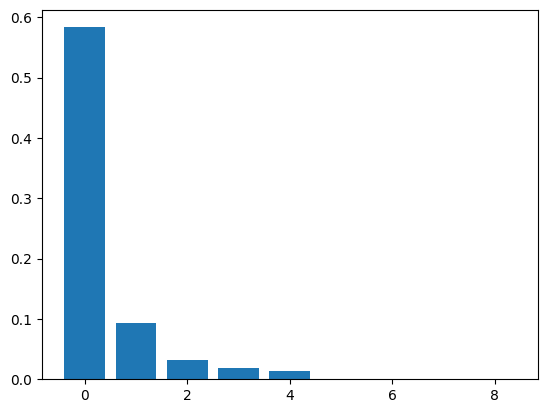

In [10]:
cov_mat = np.cov(X_normalized.T)
evs = np.linalg.eigvals(cov_mat)
plt.bar(range(len(evs)), -np.sort(-evs))
plt.show()

### Task 02.04

Use the `fit` method of a `sklearn.decomposition.PCA` model to perform a principal component analysis of this data with `n_components = 2`.

Transform the data to the latent space via the `transform` function of the PCA model.

Plot the data using a 2D scatter plot.

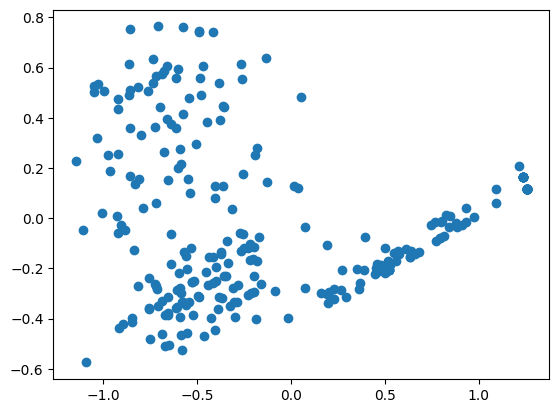

In [39]:
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(X_normalized)
new_data = pca.transform(X_normalized)
plt.scatter(new_data.T[0], new_data.T[1])
plt.show()

### Task 02.05 (Bonus Task)

Compute the eigenvalue decomposition of the covariance matrix and perform PCA yourself. Only retain the two components corresponding to the largest eigenvalues and plot the transformed data with a 2D scatter plot. Check whether your plot is consistent with the plot above.

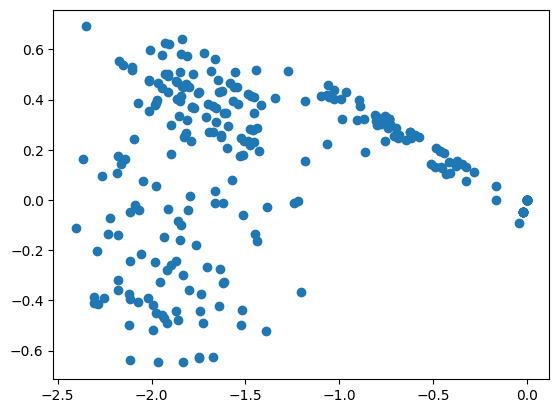

In [45]:
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
sorted_indices = np.argsort(-eigenvalues)
pcs = np.array([eigenvectors[:, sorted_indices[0]],
                eigenvectors[:, sorted_indices[1]]])

test_pca = np.matmul(pcs, X_normalized.T)
plt.scatter(test_pca[0], test_pca[1])
plt.show()

**ANSWER:** The plot is almost consistent. It is flipped because eigenvectors are invariant to sign changes.

## Factor Analysis

### Task 02.06

Use the `fit` method of a `sklearn.decomposition.FactorAnalysis` model to perform a factor analysis of this data with `n_components = 2`. Use the `rotation = 'varimax'` parameter.

Transform the data to the latent space via the `transform` function of the FA model.

Plot the data using a 2D scatter plot.

Compare this plot to the plot above. What difference do you notice?

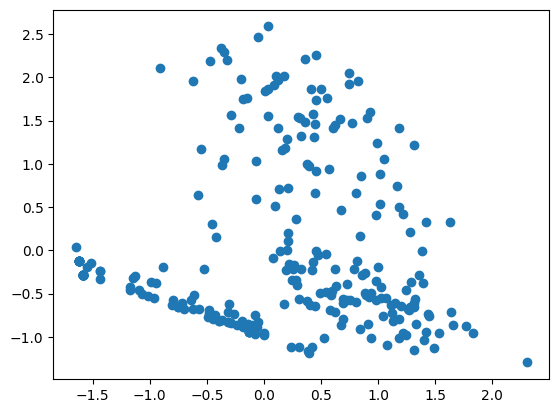

In [51]:
fa = sklearn.decomposition.FactorAnalysis(n_components=2, rotation="varimax")
fa.fit(X_normalized)
transformed = fa.transform(X_normalized)
plt.scatter(transformed.T[0], transformed.T[1])
plt.show()

**ANSWER:** I do not notice any difference, which implies, that there is no noise present in the data set

### Task 02.07

Print the factors found by the factor analysis using `print(model.components_)`. Try to interpret both factors. What does the first factor represent? What does the second factor represent?

In [53]:
print(fa.components_)

[[0.11703187 0.09086351 0.0932999  0.33418737 0.27715195 0.2760629
  0.26329229 0.26347569 0.26832181]
 [0.21847961 0.19309129 0.17895348 0.11021114 0.05045514 0.04984632
  0.04727654 0.0480017  0.05404447]]


**ANSWER:**  The first factor seems to represent the last five rows, i.e. the performance on the test. The second factor represents the first 4 rows, student activity on forums.

## K-Means Clustering

### Task 02.07

Using `sklearn.cluster.KMeans`, perform cluster analyses of the data for `n_clusters` between 2 and 10. For each value of `n_clusters`, compute the `sklearn.metrics.silhouette_score`. Provide a plot of the silhouette score on the y axis and `n_clusters` on the x axis. Report which value for `n_clusters` is best according to this analysis.

**HINT:** The `silhouette_score` function requires the cluster labels as second argument. You can retrieve the cluster labels from a fitted `KMeans` model via the `predict` function.

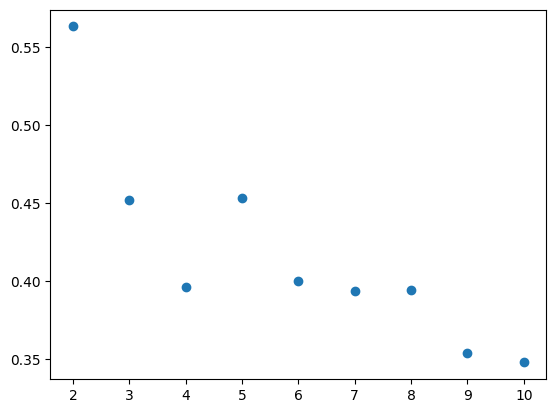

In [75]:
import sklearn.cluster
import sklearn.metrics

scores = np.zeros(9)

for k in range(2, 11):
    kmeans = sklearn.cluster.KMeans(n_clusters=k, n_init="auto").fit(X_normalized)
    scores[k - 2] = sklearn.metrics.silhouette_score(X_normalized, kmeans.labels_)
plt.scatter(range(2, 11), scores)
plt.show()

**ANSWER:** 2 clusters would be best according to this analysis

### Task 02.08

Using `sklearn.cluster.KMeans`, perform a cluster analysis of the data with `n_clusters = 2`.

Get the cluster membership of each point via the `predict` function of the KMeans model.

Provide a scatter plot of the latent representation of the data according to factor analysis, where the color of each point represents the cluster membership.

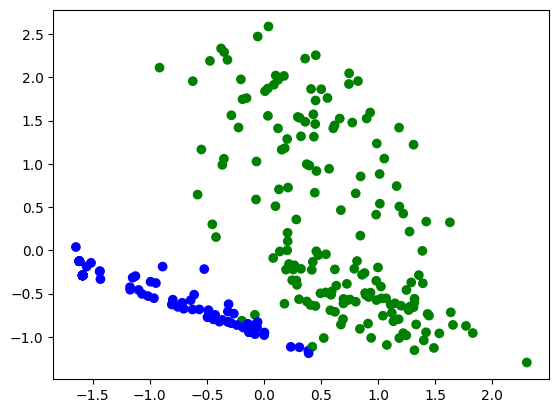

In [82]:
kmeans = sklearn.cluster.KMeans(n_clusters=2, n_init="auto").fit(X_normalized)
labels = kmeans.predict(X_normalized)
colors = list(map(lambda x: "green" if x == 0 else "blue", labels.tolist()))
plt.scatter(transformed.T[0], transformed.T[1], c=colors)

### Task 02.09 (bonus task)

Repeat the cluster analysis, but perform it on the latent representation according to factor analysis. Plot the new clustering. Check if it is consistent with the plot above.



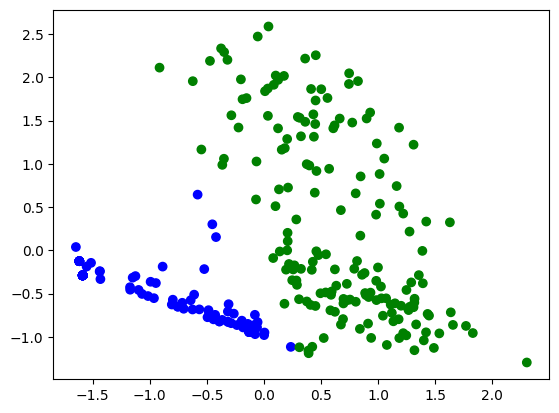

In [126]:
kmeans_fa = sklearn.cluster.KMeans(n_clusters=2, n_init="auto").fit(transformed)
labels = kmeans_fa.predict(transformed)
colors = list(map(lambda x: "green" if x == 0 else "blue", labels.tolist()))
plt.scatter(transformed.T[0], transformed.T[1], c=colors)

**ANSWER** Results are not consistent with the above plot, which makes sense since after transformation distance between two points has been distorted.

### Task 02.10 (bonus task)

Implement $K$-Means yourself. Check if your result is consistent with the result provided by the `sklearn` implementation.


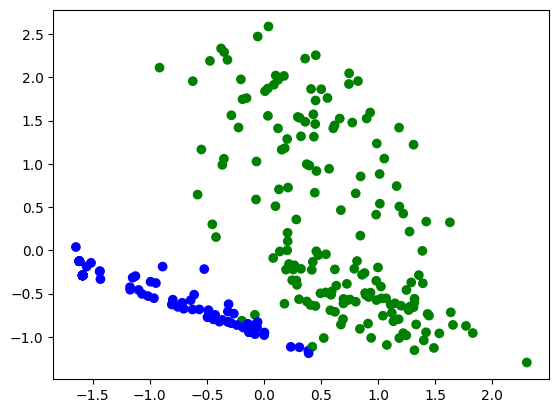

In [114]:
def k_means(data, k):
    # setup
    num_entries = data.shape[0]
    num_features = data.shape[1]
    labels = np.zeros(num_entries)
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    centers = data_mean + data_std * np.random.standard_normal((k, num_features))

    centers_changed = True
    while centers_changed:
        # inner loop
        for i in range(num_entries):
            entry = data[i]
            min_dist = float("inf")
            closest = 0
            for j, center in enumerate(centers):
                dist = np.linalg.norm(entry - center)
                if dist < min_dist:
                    min_dist = dist
                    closest = j
            labels[i] = closest
        any_center_changed = False
        for c in range(k):
            indices = np.where(labels == c)
            new_center = np.mean(data[indices], axis=0)
            old_center = centers[c]
            if (new_center != old_center).all():
                centers[c] = new_center
                any_center_changed = True
        if not any_center_changed:
            centers_changed = False
    return labels


labels = k_means(X_normalized, 2)
colors = list(map(lambda x: "green" if x == 0 else "blue", labels.tolist()))
plt.scatter(transformed.T[0], transformed.T[1], c=colors)

**ANSWER** Result is consistent.

## Gaussian Mixture Models

### Task 02.11

Using `sklearn.mixture.GaussianMixture`, perform cluster analyses of the data with `n_components` between 2 and 10. For each cluster analysis, compute the `bic` function value of the model (this is the Bayesian information criterion). Provide a plot of the bic value on the y axis with `n_components` on the x axis.

Report which value for `n_components` is best according to this analysis.

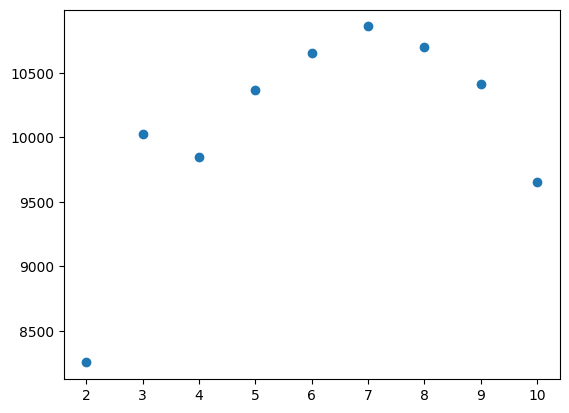

In [136]:
import sklearn.mixture

for k in range(2, 11):
    gmm = sklearn.mixture.GaussianMixture(n_components=k).fit(X_normalized)
    scores[k - 2] = -gmm.bic(X_normalized)
plt.scatter(range(2, 11), scores)
plt.show()

**ANSWER:** The best is 7 (but this changes due to random initialization), so please don't execute.

### Task 02.12

Using `sklearn.mixture.GaussianMixture`, perform a cluster analysis of the data with `n_components = 2`.

Get the cluster membership of each point via the `predict` function of the GaussianMixture model.

Provide a scatter plot of the latent representation of the data according to factor analysis, where the color of each point represents the cluster membership.

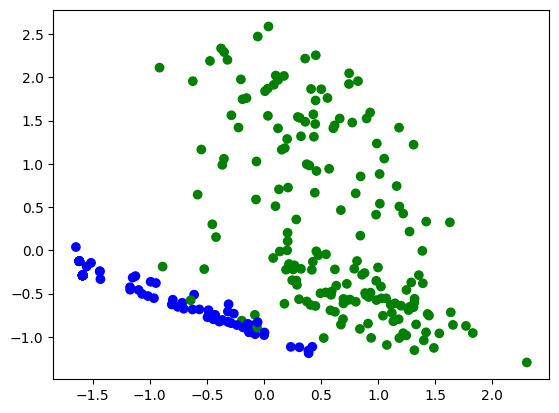

In [139]:
gmm = sklearn.mixture.GaussianMixture(n_components=2).fit(X_normalized)
labels = gmm.predict(X_normalized)
colors = list(map(lambda x: "green" if x == 0 else "blue", labels.tolist()))
plt.scatter(transformed.T[0], transformed.T[1], c=colors)

### Task 02.13

Using `sklearn.mixture.GaussianMixture`, perform a cluster analysis of the latent space representation according to factor analysis with `n_components = 3`.

Get the cluster membership of each point via the `predict` function of the GaussianMixture model.

Provide a scatter plot, where the color of each point represents the cluster membership.

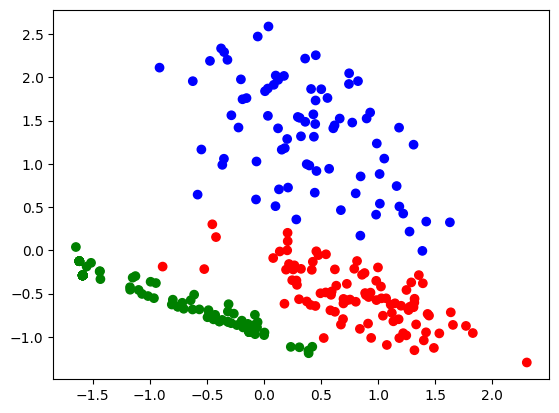

In [144]:
gmm = sklearn.mixture.GaussianMixture(n_components=3).fit(transformed)
labels = gmm.predict(transformed)
colors = list(map(lambda x: "green" if x == 0 else "red" if x == 1 else "blue", labels.tolist()))
plt.scatter(transformed.T[0], transformed.T[1], c=colors)

### Task 02.14

Print the mean feature values for each cluster. Try to interpret the clusters: What characterizes the differenct clusters?

In [153]:
def pretty_print_entry(entry):
    for i in range(len(features)):
        print(f"{features[i]}: {entry[i]}")

for i in range(3):
    idxs = np.where(labels==i)
    entries = X_normalized[idxs]
    print(f"Cluster {i}")
    pretty_print_entry(np.mean(entries, axis=0))

Cluster 0
num_forum_postings: 0.01758409785932721
num_questions: 0.0
num_messages: 0.0
num_completed_tasks: 0.23669724770642195
points_exercise_1: 0.15449541284403673
points_exercise_2: 0.15082568807339444
points_exercise_3: 0.14481477180350716
points_exercise_4: 0.1460534974644834
points_exercise_5: 0.14639692621344
Cluster 1
num_forum_postings: 0.20572916666666674
num_questions: 0.12499999999999996
num_messages: 0.16435185185185167
num_completed_tasks: 1.0
points_exercise_1: 0.6545833333333336
points_exercise_2: 0.6551388888888888
points_exercise_3: 0.6240770042194093
points_exercise_4: 0.6217035864978901
points_exercise_5: 0.6320779914529916
Cluster 2
num_forum_postings: 0.6276371308016876
num_questions: 0.521518987341772
num_messages: 0.49507735583684936
num_completed_tasks: 0.9518987341772153
points_exercise_1: 0.6308860759493669
points_exercise_2: 0.6234599156118144
points_exercise_3: 0.5949367088607594
points_exercise_4: 0.5962719649628797
points_exercise_5: 0.6179135562046955


**ANSWER:**

Cluster 0:
- little forum engagement
- poor test performance and attendance

Cluster 1:
- decent forum activity
- good test performance

Cluster 2:
- high forum activity
- good test performance

### Task 02.15

Recall the equation for the expected negative log likelihood in a Gaussian mixture model from the lecture:

\begin{align*}
Q = &\sum_{i=1}^N \sum_{k=1}^K -\gamma_{k,i} \cdot \log\Big[ p_{X|Z}(x_i|k) \cdot p_Z(k) \Big]\\
=& \sum_{i=1}^N \sum_{k=1}^K \gamma_{k,i} \cdot \Big(\frac{1}{2}\log[2\pi \det(\Sigma_k)] + \frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k) - \log[p_Z(k)]\Big)
\end{align*}

Assuming that $Q$ is convex, find the optimal values for $\mu_k$ and $\Sigma_k$

**HINT:** You may use the following general matrix/vector gradient equations (refer to the [matrix cook book by Peterson and Pedersen (2012), p.10-11](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) :
\begin{align*}
\nabla_x (x - y)^T W (x - y) &= 2 W (x-y) \\
\nabla_W (x - y)^T W (x - y) &= (x-y)(x-y)^T \\
\nabla_{W^{-1}} \log[\det(W)] &= -W & \text{if $W$ is symmetric and positive semi-definite}
\end{align*}

**ANSWER:**
First: $\mu_j$ (because k is already used in the sum)
\begin{align*}
Q =& \sum_{i=1}^N \sum_{k=1}^K \gamma_{k,i} \cdot \Big(\frac{1}{2}\log[2\pi \det(\Sigma_k)] + \frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k) - \log[p_Z(k)]\Big)\\
\Delta_{\mu_j}Q =& \Delta_{\mu_j} \left( \sum_{i=1}^N \sum_{k=1}^K \gamma_{k,i} \cdot \Big(\frac{1}{2}\log[2\pi \det(\Sigma_k)] + \frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k) - \log[p_Z(k)]\Big) \right)\\
=& \sum_{i=1}^N \sum_{k=1}^K \gamma_{k,i} \cdot \Big(\Delta_{\mu_j}\frac{1}{2}\log[2\pi \det(\Sigma_k)] + \Delta_{\mu_j}\frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k) - \Delta_{\mu_j}\log[p_Z(k)]\Big)\\
=& \sum_{i=1}^N \sum_{k=1}^K \gamma_{k,i} \cdot \Big(\Delta_{\mu_j}\frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k)\Big)\\
=& \sum_{i=1}^N \gamma_{j,i} \cdot \Big(\Delta_{\mu_j}\frac{1}{2} (x_i - \mu_j)^T \Sigma_j^{-1} (x_i - \mu_j)\Big)\\
=& \sum_{i=1}^N \gamma_{j,i} \cdot \Big(\frac{1}{2} \cdot 2 \Sigma_j^{-1} (x_i - \mu_j) \Big)\\
\end{align*}
Set to zero to find optimum (convex etc):
\begin{align*}
    & 0 = \sum_{i=1}^N \gamma_{j,i} \cdot \Big( \Sigma_j^{-1} (x_i - \mu_j) \Big) \\
    \iff& 0 = \sum_{i=1}^N \gamma_{j,i} \cdot (x_i - \mu_j)\\
    \iff& 0 = \sum_{i=1}^N (\gamma_{j,i} x_i)- \sum^N_{i=1} \gamma_{j,i} \mu_j \\
    \iff& \sum^N_{i=1} \gamma_{j,i} \mu_j = \sum_{i=1}^N (\gamma_{j,i} x_i) \\
    \iff& \mu_j = \frac{\sum_{i=1}^N (\gamma_{j,i} x_i)}{ \sum^N_{i=1} \gamma_{j,i} } \\
\end{align*}

Second: $\Sigma_j$
\begin{align*}
Q =& \sum_{i=1}^N \sum_{k=1}^K \gamma_{k,i} \cdot \Big(\frac{1}{2}\log[2\pi \det(\Sigma_k)] + \frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k) - \log[p_Z(k)]\Big)\\
\Delta_{\Sigma_j}Q =& \Delta_{\Sigma_j} \left( \sum_{i=1}^N \sum_{k=1}^K \gamma_{k,i} \cdot \Big(\frac{1}{2}\log[2\pi \det(\Sigma_k)] + \frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k) - \log[p_Z(k)]\Big) \right)\\
=& \sum_{i=1}^N \sum_{k=1}^K \gamma_{k,i} \cdot \Big(\Delta_{\Sigma_j}\frac{1}{2}\log[2\pi \det(\Sigma_k)] + \Delta_{\Sigma_j}\frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k) - \Delta_{\Sigma_j}\log[p_Z(k)]\Big)\\
=& \sum_{i=1}^N \sum_{k=1}^K \gamma_{k,i} \cdot \Big(\Delta_{\Sigma_j}\frac{1}{2}\log[2\pi \det(\Sigma_k)] + \Delta_{\Sigma_j}\frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k)\Big)\\
=& \sum_{i=1}^N \sum_{k=1}^K \gamma_{k,i} \cdot \Big(\frac{1}{2}\cdot2\pi (-\Sigma_k) + \frac{1}{2} (x_i - \mu_k)(x_i - \mu_k)^T\Big)\\
=& \sum_{i=1}^N\gamma_{j,i} \cdot \Big(-\pi \Sigma_j + \frac{1}{2} (x_i - \mu_k)(x_i - \mu_k)^T\Big)\\
\end{align*}

Set to zero to find optimum:
\begin{align*}
    & 0 = \sum_{i=1}^N\gamma_{j,i} \cdot \Big(-\pi \Sigma_j + \frac{1}{2} (x_i - \mu_k)(x_i - \mu_k)^T\Big) \\
    & 0 = \sum_{i=1}^N-\Big(\gamma_{j,i} \pi \Sigma_j\Big) + \sum_{i=1}^N\Big(\gamma_{j,i} \frac{1}{2} (x_i - \mu_k)(x_i - \mu_k)^T\Big) \\
    & \sum_{i=1}^N\Big(\gamma_{j,i} \pi \Sigma_j\Big) =  \sum_{i=1}^N\Big(\gamma_{j,i} \frac{1}{2} (x_i - \mu_k)(x_i - \mu_k)^T\Big) \\
    & \Sigma_j\sum_{i=1}^N\Big(\gamma_{j,i} \pi \Big) =  \sum_{i=1}^N\Big(\gamma_{j,i} \frac{1}{2} (x_i - \mu_k)(x_i - \mu_k)^T\Big) \\
    & \Sigma_j =  \frac{\sum_{i=1}^N\Big(\gamma_{j,i} \frac{1}{2} (x_i - \mu_k)(x_i - \mu_k)^T\Big)}{\sum_{i=1}^N\Big(\gamma_{j,i} \pi \Big)} \\
\end{align*}